# VGG trained on ImageNet was used to extract features and transfer learning was performed
## The resulting features were 10 x 10 x 512. i.e. a total of 51,200 when flattened. These features were fed to a regular dense ANN producing Mean Sq.Error of 0.07 which was much better than our CNN's M.S.E. of 0.24. Prima facie this seems great, VGG has been trained on millions of images and can obviously detect edges, lines and all sorts of geometric properties better than the convolution layers in our custom CNN. 

## However our CNN produced MSE of 0.21 on test set whereas transfer learnt model produced 0.19. This indicates VGG transfer Learnt Model severely overfits. 

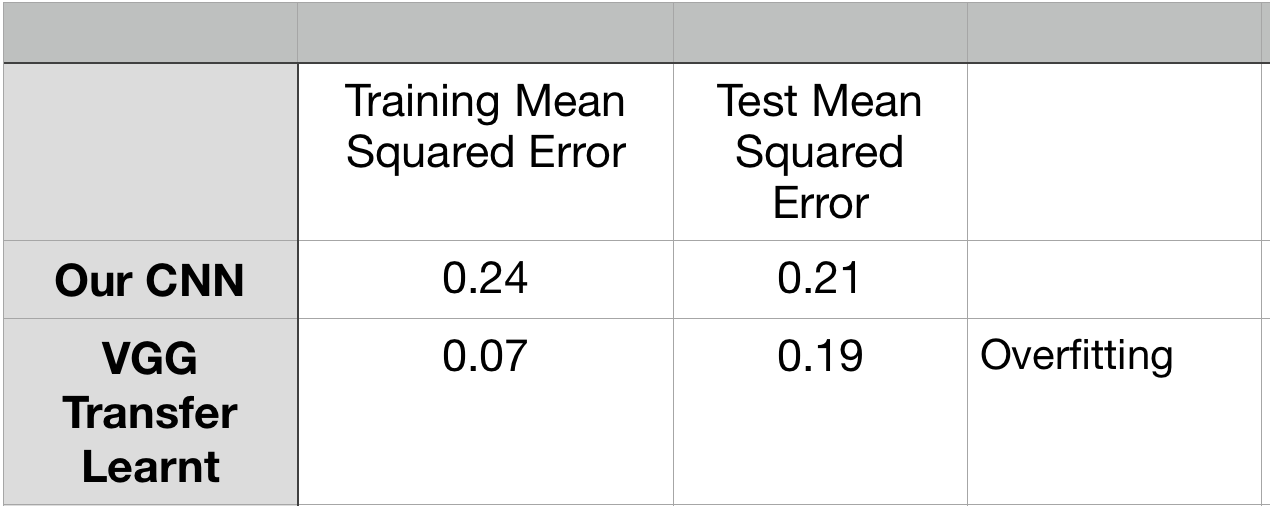

In [4]:
import numpy as np
import PIL,os
from PIL import Image
import glob, random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn import metrics


import seaborn as sns

from keras.applications.vgg16 import VGG16


In [41]:
#np.savez_compressed('traintest.npz', X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test, names_train = names_train,names_test = names_test)

In [6]:
traintest = np.load('traintest.npz')

In [7]:
traintest.files

['X_train', 'y_train', 'X_test', 'y_test', 'names_train', 'names_test']

In [8]:
traintest['names_test']

array(['AF1.jpg', 'AF100.jpg', 'AF1007.jpg', ..., 'CM84.jpg', 'CM88.jpg',
       'CM96.jpg'], dtype='<U10')

In [9]:
X_train = traintest['X_train']
X_test = traintest['X_test']
y_train = traintest['y_train']
y_test = traintest['y_test']

In [18]:
X_train.shape

(4400, 350, 350, 3)

# Feature Extractor

In [14]:
#############################
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(350, 350, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 350, 350, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 350, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 350, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 175, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 175, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 175, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 87, 128)       0     

In [20]:
#Now, let us use features from convolutional network for random forest or ANN
feature_extractor=VGG_model.predict(X_train, verbose=1)

138/138 [==============================] - 2340s 17s/step


In [21]:
ann = models.Sequential([
    # each filter is a feature detector. Convolving feature detector with original image gives feature map 
#     layers.Conv2D(filters=100, kernel_size=(10, 10), activation='relu', input_shape=(350, 350, 3)),
#     layers.MaxPooling2D((10, 10)),
    
#     layers.Conv2D(filters=50, kernel_size=(10, 10), activation='relu'),
#     layers.MaxPooling2D((10, 10)),
    
    # conventional ann
    layers.Flatten(input_shape=(10, 10, 512)),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

In [22]:
ann.compile(optimizer='adam',
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

In [23]:
ann.fit(feature_extractor, y_train, epochs=5)

Epoch 1/5
138/138 [==============================] - 3s 8ms/step - loss: 2.1897 - mean_squared_error: 2.1897
Epoch 2/5
138/138 [==============================] - 1s 7ms/step - loss: 0.1551 - mean_squared_error: 0.1551
Epoch 3/5
138/138 [==============================] - 1s 7ms/step - loss: 0.1162 - mean_squared_error: 0.1162
Epoch 4/5
138/138 [==============================] - 1s 7ms/step - loss: 0.0911 - mean_squared_error: 0.0911
Epoch 5/5
138/138 [==============================] - 1s 7ms/step - loss: 0.0782 - mean_squared_error: 0.0782


In [24]:
# 1st do feature transformations on X_test

feature_extractor_test=VGG_model.predict(X_test, verbose=1)  

35/35 [==============================] - 572s 16s/step


In [26]:
ann.evaluate(feature_extractor_test,y_test)

35/35 [==============================] - 0s 3ms/step - loss: 0.1906 - mean_squared_error: 0.1906


[0.19063855707645416, 0.19063855707645416]

# -------------------------------------END------------------------------------------